## ODIN EDA

### Imports and reading data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Valuables not available are encoded as '#NULL!'
df = pd.read_csv("data/ODiN2022_Databestand.csv", sep=";", encoding="latin1", na_values="#NULL!")
print(len(df))
df.head(5)

200054


,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,...,RReisduur,RReisduurBL,RVertStat,RAankStat,RTSamen,RCorrSnelh,RVliegVer,FactorH,FactorP,FactorV
0,1,300000269880,8,1,1,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148,148,54076
1,1,300000882980,1,1,2,2,3,0,0,0,...,5.0,0.0,0.0,0.0,13.0,0.0,0.0,176,353,128711
2,0,300000882980,1,1,2,2,3,0,0,0,...,15.0,0.0,0.0,0.0,13.0,0.0,0.0,176,353,128711
3,0,300000882980,1,1,2,2,3,0,0,0,...,114.0,0.0,0.0,0.0,13.0,6.0,0.0,176,353,128711
4,1,300000883980,1,1,3,3,3,0,0,0,...,45.0,0.0,0.0,0.0,13.0,0.0,0.0,140,421,153774


In [3]:
# Combine 'Jaar', 'Maand' and 'Dag' to a single Datum column.
df["Datum"] = pd.to_datetime(df[["Jaar", "Maand", "Dag"]].astype(str).agg('-'.join, axis=1))

In [4]:
print(df.columns.tolist())

['OP', 'OPID', 'Steekproef', 'Mode', 'HHPers', 'HHSam', 'HHPlOP', 'HHLft1', 'HHLft2', 'HHLft3', 'HHLft4', 'WoPC', 'WoGem', 'Sted', 'GemGr', 'Prov', 'Corop', 'BuurtAdam', 'MRA', 'MRDH', 'Utr', 'Geslacht', 'Leeftijd', 'KLeeft', 'Herkomst', 'BetWerk', 'OnbBez', 'MaatsPart', 'Opleiding', 'HHBestInkG', 'HHGestInkG', 'HHLaagInk', 'HHSocInk', 'HHWelvG', 'HHRijbewijsAu', 'HHRijbewijsMo', 'HHRijbewijsBr', 'OPRijbewijsAu', 'OPRijbewijsMo', 'OPRijbewijsBr', 'HHAuto', 'HHAutoL', 'OPAuto', 'BrandstofPa1', 'XBrandstofPa1', 'BrandstofEPa1', 'BouwjaarPa1', 'KBouwjaarPa1', 'KGewichtPa1', 'TenaamPa1', 'BrandstofPa2', 'XBrandstofPa2', 'BrandstofEPa2', 'BouwjaarPa2', 'KBouwjaarPa2', 'KGewichtPa2', 'TenaamPa2', 'BrandstofPaL', 'XBrandstofPaL', 'BrandstofEPaL', 'BouwjaarPaL', 'KBouwjaarPaL', 'KGewichtPaL', 'HHMotor', 'OPMotor', 'HHBrom', 'OPBrom', 'HHSnor', 'OPSnor', 'HHEFiets', 'HHBezitVm', 'OPBezitVm', 'FqLopen', 'FqNEFiets', 'FqEFiets', 'FqBTM', 'FqTrein', 'FqAutoB', 'FqAutoP', 'FqBrSnor', 'FqMotor', 'OV

### Exploration

In [5]:
# Read codebook Excel
codebook = pd.read_excel("data/ODiN2022_Codeboek_v1.0.xlsx", usecols=["Variabele_naam_ODiN_2022", "Variabele_label_ODiN_2022"])
# Drop rows with NaN
codebook = codebook.dropna()
codebook.head()

C:\Users\Ewout\.virtualenvs\Py312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Variabele_naam_ODiN_2022,Variabele_label_ODiN_2022
0,OP,Nieuwe persoon
3,OPID,Uniek id voor iedere OP
5,Steekproef,Steekproefindicator
10,Mode,Responsmode
12,HHPers,Aantal personen in huishouden


In [6]:
codebook_dict = codebook.set_index("Variabele_naam_ODiN_2022")["Variabele_label_ODiN_2022"].to_dict()

In [7]:
# Load the Excel file
excel_path = 'data/ODiN2022_Codeboek_v1.0.xlsx'
df_codebook = pd.read_excel(excel_path)

# Initialize the nested dictionary
codebook_labels = {}

# Initialize a variable to keep track of the current variable name
current_var_name = None

# Iterate over the DataFrame rows
for _, row in df_codebook.iterrows():
    # Check if the row contains a new variable name
    if pd.notna(row['Variabele_naam_ODiN_2022']):
        current_var_name = row['Variabele_naam_ODiN_2022']
        codebook_labels[current_var_name] = {}

    # If the row contains a code, add it to the current variable's dictionary
    if pd.notna(row['Code_ODiN_2022']) and pd.notna(row['Code_label_ODiN_2022']):
        codebook_labels[current_var_name][row['Code_ODiN_2022']] = row['Code_label_ODiN_2022']

codebook_labels["Doel"]

C:\Users\Ewout\.virtualenvs\Py312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


{'<missing>': 'missing indien geen verplaatsing',
 1: 'Naar huis',
 2: 'Werken',
 3: 'Zakelijk bezoek in werksfeer',
 4: 'Beroepsmatig',
 5: 'Afhalen/brengen personen',
 6: 'Afhalen/brengen goederen',
 7: 'Onderwijs/cursus volgen',
 8: 'Winkelen/boodschappen doen',
 9: 'Visite/logeren',
 10: 'Toeren/wandelen',
 11: 'Sport/hobby',
 12: 'Overige vrijetijdsbesteding',
 13: 'Diensten/persoonlijke verzorging',
 14: 'Ander doel'}

#### How many trips does a single person make?

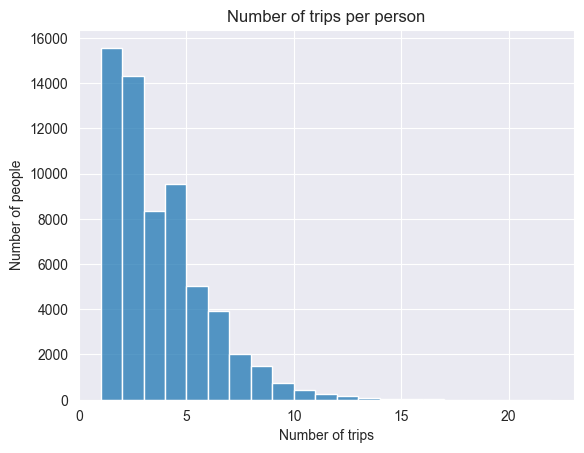

In [8]:
# Value counts when both OPID and datum are both identical
trip_counts = (df["OPID"].astype(str) + "_" + df["Datum"].astype(str)).value_counts()

# Create a historgram of the trip counts
sns.histplot(trip_counts, kde=False, binwidth=1)
# Add title and labels
plt.title('Number of trips per person')
plt.xlabel('Number of trips')
plt.ylabel('Number of people')
# Save the plot as a PNG file
plt.savefig("img/trip_counts_histogram.png", dpi=300, bbox_inches='tight')

In [9]:
# Average and median number of trips
print(f"Average number of trips: {trip_counts.mean()}")
print(f"Median number of trips: {trip_counts.median()}")

Average number of trips: 3.2291253046664408
Median number of trips: 3.0


#### How long are trips for each mode of transport?

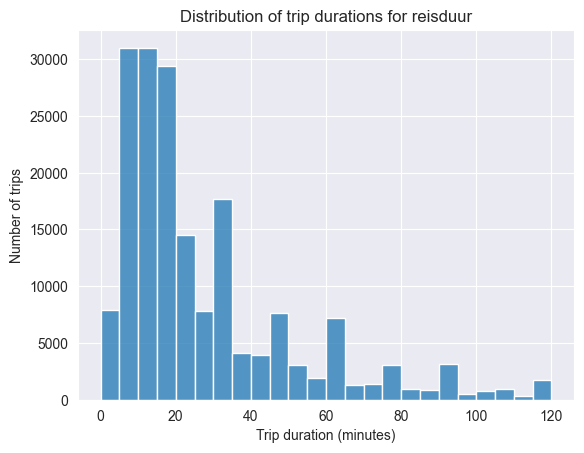

In [10]:
# Create a histogram of the trip durations
sns.histplot(df["Reisduur"], kde=False, binwidth=5, binrange=(0, 120))
# Add title and labels
plt.title(f'Distribution of trip durations for reisduur')
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')
plt.savefig("img/trip_durations_histogram.png", dpi=300, bbox_inches='tight')

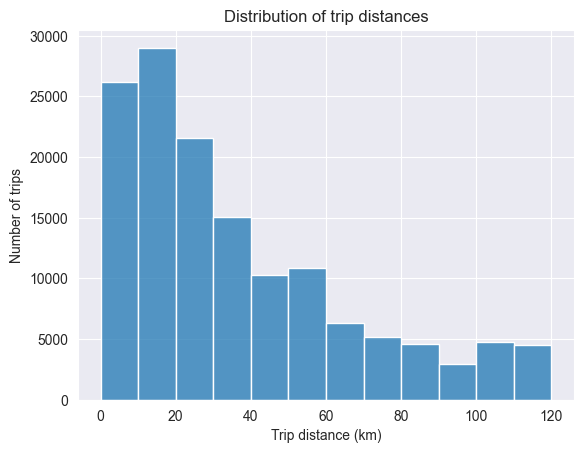

In [11]:
# Create a histogram of the trip distances
sns.histplot(df["AfstV"], kde=False, binwidth=10, binrange=(0, 120))
# Add title and labels
plt.title("Distribution of trip distances")
plt.xlabel("Trip distance (km)")
plt.ylabel("Number of trips")
plt.savefig("img/trip_distances_histogram.png", dpi=300, bbox_inches='tight')

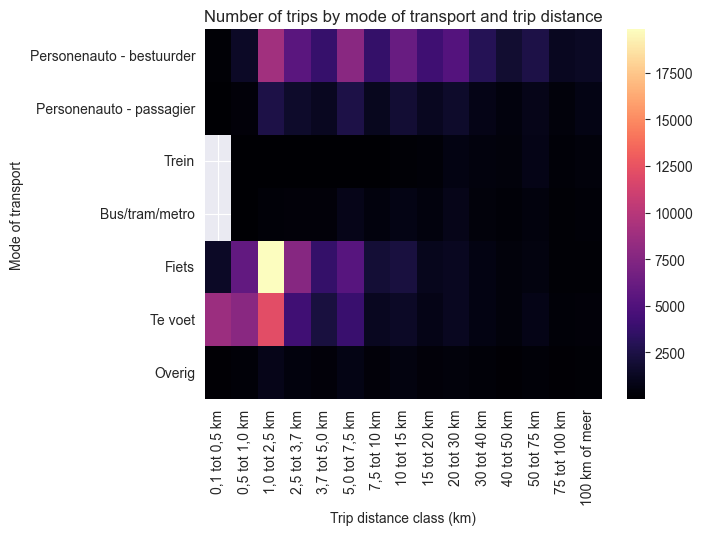

In [12]:
# Create a heatmap of trip distances by mode of transport
pivot_table = df.pivot_table(index="KRvm", columns="KAfstV", values="OPID", aggfunc="count")
# Replace the mode codes with the mode labels (from the codebook)
pivot_table.index = pivot_table.index.map(codebook_labels["KRvm"])
pivot_table.columns = pivot_table.columns.map(codebook_labels["KAfstV"])
pivot_table = pivot_table.drop("Geen reguliere verplaatsing in Nederland", axis=1)
# Create a heatmap
sns.heatmap(pivot_table, cmap="magma")
# Add title and labels
plt.title("Number of trips by mode of transport and trip distance")
plt.xlabel("Trip distance class (km)")
plt.ylabel("Mode of transport")
# Save the plot as a PNG file
plt.savefig("img/trips_by_mode_and_distance_heatmap.png", dpi=300, bbox_inches='tight')

#### How many trips are made during the week?

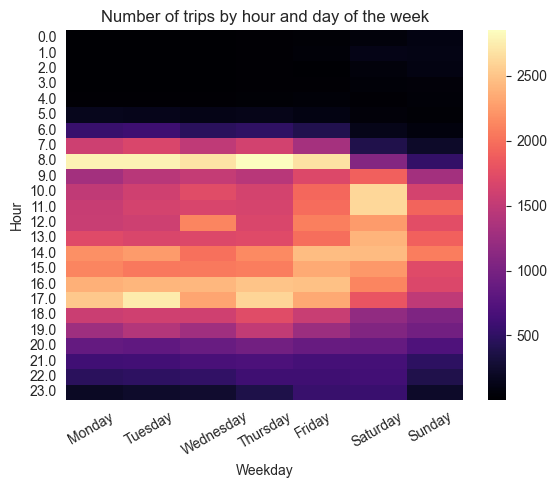

In [13]:
# Calculate the number of trips by hour in the week
df["Hour"] = df["VertUur"]
df["Weekday"] = df["Datum"].dt.dayofweek
df["Weekend"] = df["Weekday"] >= 5

# Create a pivot table with the number of trips by hour and day of the week
trips_by_hour = df.pivot_table(index="Hour", columns="Weekday", values="OPID", aggfunc="count")

# Plot the pivot table as a heatmap
sns.heatmap(trips_by_hour, cmap="magma")
plt.title('Number of trips by hour and day of the week')
plt.xlabel('Weekday')
plt.ylabel('Hour')
# Align the x-axis labels centered
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=30, ha="left")
plt.savefig("img/trips_by_weekday_and_hour_heatmap.png", dpi=300, bbox_inches='tight')

#### How many trips are made by each mode of transport?

In [14]:
# Create a function to create a circle plot from a variable name
def create_circle_plot(variable_name, title):
    # Create a circle plot of the number of trips by mode of transport
    counts = df[variable_name].value_counts()
    # Replace the mode codes with the mode labels (from the codebook)
    counts.index = counts.index.map(codebook_labels[variable_name])

    # Plot the circle plot with seaborn
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)

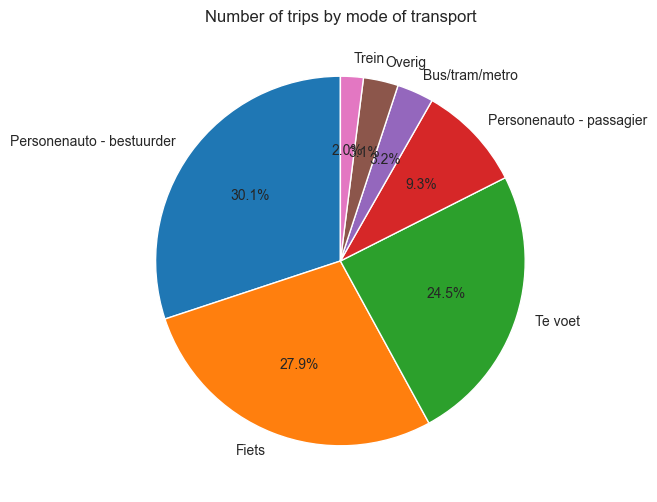

In [15]:
# Create a circle plot of the number of trips by mode of transport
create_circle_plot("KRvm", "Number of trips by mode of transport")
plt.savefig("img/trips_by_mode_circle_plot.png", dpi=300, bbox_inches='tight')

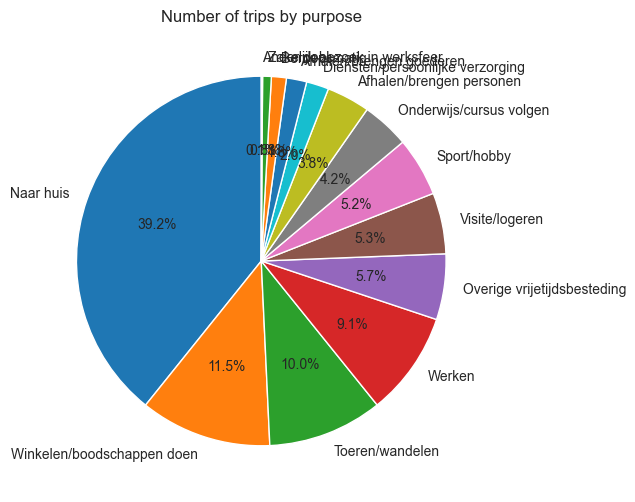

In [16]:
# Doel and Motive
create_circle_plot("Doel", "Number of trips by purpose")
plt.savefig("img/trips_by_purpose_circle_plot.png", dpi=300, bbox_inches='tight')

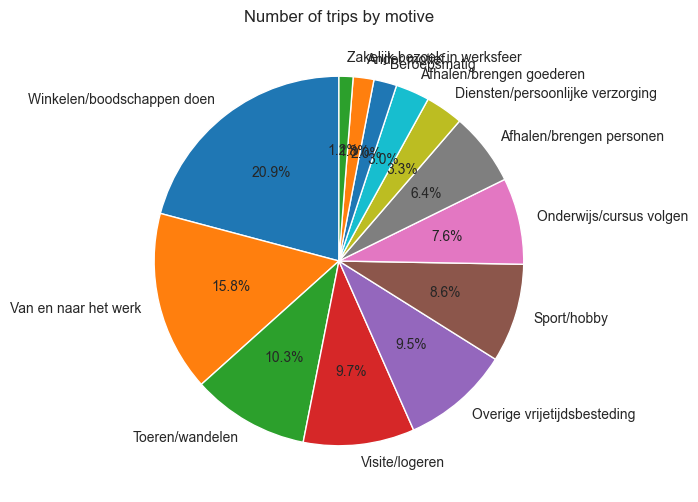

In [17]:
create_circle_plot("MotiefV", "Number of trips by motive")
plt.savefig("img/trips_by_motive_circle_plot.png", dpi=300, bbox_inches='tight')

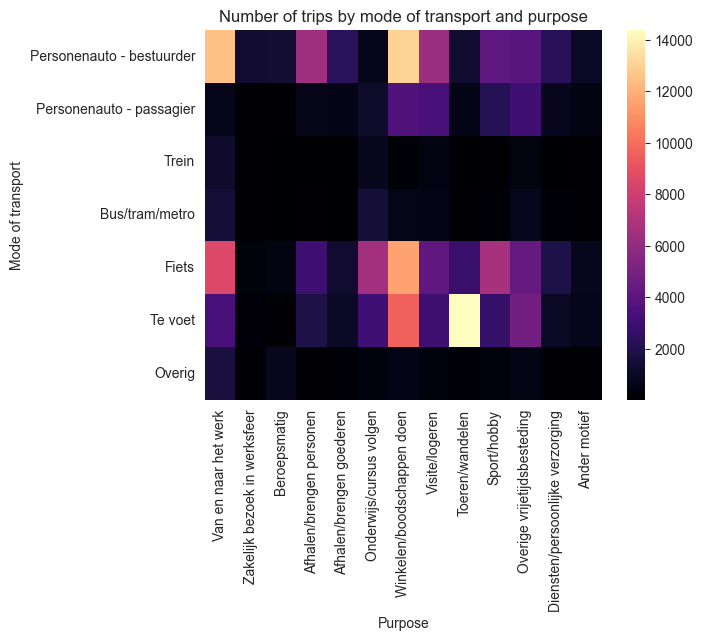

In [18]:
# Create a heatmap of the number of trips by mode of transport and purpose
pivot_table = df.pivot_table(index="KRvm", columns="MotiefV", values="OPID", aggfunc="count")
# Replace the mode codes with the mode labels (from the codebook)
pivot_table.index = pivot_table.index.map(codebook_labels["KRvm"])
pivot_table.columns = pivot_table.columns.map(codebook_labels["MotiefV"])
# Create a heatmap
sns.heatmap(pivot_table, cmap="magma")
# Add title and labels
plt.title("Number of trips by mode of transport and purpose")
plt.xlabel("Purpose")
plt.ylabel("Mode of transport")
# Save the plot as a PNG file
plt.savefig("img/trips_by_mode_and_purpose_heatmap.png", dpi=300, bbox_inches='tight')

### EDA

In [19]:
# Drop all rows that have a missing value in the KRvm column
df = df.dropna(subset=["KRvm"])
len(df)

188035

In [20]:
variables_to_include = ["KRvm", "Sted", "GemGr", "Doel", "MotiefV", "AfstV", "Reisduur", "VertUur", "Weekdag", "Maand", "Feestdag", "Prov", "Geslacht", "Leeftijd", "Herkomst", "Opleiding", "BetWerk", "OnbBez", "HHGestInkG", "HHRijbewijsAu", "OPRijbewijsAu", "HHAuto", "HHAutoL", "BrandstofPa1", "BouwjaarPa1", "HHEFiets", "OVStKaart", "WrkVerg", "VergVast", "AantRit", "Verpl", "Toer", "MeerWink", "VertLoc", "ActDuur", "SDezPlts"]

In [21]:
# Choose a dataframe to use here:
df_to_split = df[variables_to_include].copy()

# Split in input and output variable
X = df_to_split.drop('KRvm', axis=1)
y = df_to_split['KRvm']

In [22]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

### Model selection and development
 - Choose appropriate algorithms: Select suitable machine learning algorithms based on your problem type, such as logistic regression, decision trees, random forests, support vector machines, or neural networks.
 - Train the models: Train the selected algorithms on the training dataset and use the validation dataset to tune hyperparameters and assess performance.
 - Model evaluation: Compare the performance of the different models using relevant evaluation metrics such as accuracy, precision, recall, F1-score, or AUC-ROC.

Output: `results_df`

In [23]:
# Mode dict from codebook
mode_dict = codebook_labels["KRvm"]
mode_dict

{'<missing>': 'missing indien geen verplaatsing of indien een serieverplaatsing',
 1: 'Personenauto - bestuurder',
 2: 'Personenauto - passagier',
 3: 'Trein',
 4: 'Bus/tram/metro',
 5: 'Fiets',
 6: 'Te voet',
 7: 'Overig'}

In [24]:
# Imports
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Create a dictionary combining the methods and method names. Write it out fully.
method_dict = {'Random Forests': RandomForestClassifier(),
               # 'Neural Networks': MLPClassifier(),
               # 'Logistic Regression': LogisticRegression(),
               #'K-Nearest Neighbors': KNeighborsClassifier(),
               #'Support Vector Machines': SVC(),
               'Decision Trees': DecisionTreeClassifier(),
               #'Gradient Boosting': GradientBoostingClassifier(),
               #'AdaBoost': AdaBoostClassifier()
             }

def get_accuracies(method_dict, X_train, y_train, X_val, y_val):
    # Create a dictionary to store the method accuracies
    method_accuracies = {}

    # Loop through the methods and print the accuracy
    for method_name, method in method_dict.items():
        method.fit(X_train, y_train)
        y_pred = method.predict(X_val)

        # Calculate total and balanced accuracy
        accuracy = accuracy_score(y_val, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred)

        # Calculate the accuracies for each of the 3 categories using a from confusion_matrix
        cm = confusion_matrix(y_val, y_pred)
        category_accuracy = cm.diagonal() / cm.sum(axis=1)


        accuracy_list = [accuracy, balanced_accuracy]  + list(category_accuracy)
        method_accuracies[method_name] = accuracy_list

    # Create a dataframe from the dictionary
    return pd.DataFrame.from_dict(method_accuracies, orient='index', columns=['Total accuracy', 'Balanced accuracy'] + [f"{mode_dict[i]} accuracy" for i in range(1, 8)])

In [25]:
# Create a dataframe from the dictionary
df_accuracies = get_accuracies(method_dict=method_dict, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
df_accuracies.sort_values("Total accuracy", ascending=False)

,Total accuracy,Balanced accuracy,Personenauto - bestuurder accuracy,Personenauto - passagier accuracy,Trein accuracy,Bus/tram/metro accuracy,Fiets accuracy,Te voet accuracy,Overig accuracy
Random Forests,0.702228,0.470410,0.867958,0.349310,0.241985,0.202097,0.716397,0.792245,0.122877
Decision Trees,0.612198,0.455623,0.697178,0.441267,0.219847,0.287893,0.603173,0.704736,0.235265


Accuracy: 61.279098%
Accuracy: 68.116577% (0.379587%)
0.6824793256574574
              precision    recall  f1-score   support

         1.0       0.78      0.77      0.77     56571
         2.0       0.54      0.56      0.55     17481
         3.0       0.08      0.10      0.09      3753
         4.0       0.23      0.24      0.24      6035
         5.0       0.70      0.70      0.70     52413
         6.0       0.76      0.74      0.75     46045
         7.0       0.39      0.40      0.40      5737

    accuracy                           0.68    188035
   macro avg       0.50      0.50      0.50    188035
weighted avg       0.69      0.68      0.68    188035


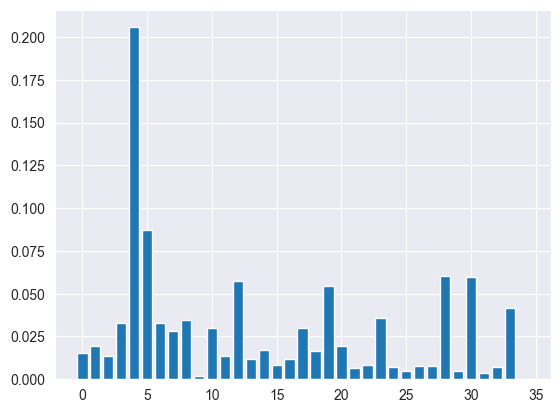

In [26]:
# Gradient boosting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
model_GB = DecisionTreeClassifier()
model_GB.fit(X_train, y_train)
# make predictions for validation data
y_pred = model_GB.predict(X_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.6f%%" % (accuracy * 100.0))

# Kfold
kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model_GB, X, y, cv=kfold)
print("Accuracy: %.6f%% (%.6f%%)" % (results.mean()*100, results.std()*100))

# Feature importance
from matplotlib import pyplot
pyplot.bar(range(len(model_GB.feature_importances_)),
model_GB.feature_importances_)

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict

predicted = model_selection.cross_val_predict(model_GB, X, y, cv=kfold)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

In [27]:
# Gradient boosting top 20 important features
first_importances = pd.Series(model_GB.feature_importances_, index = X.columns)
sorted_first = first_importances.sort_values(ascending = False)
top_20_first = sorted_first.head(50)
first_list = top_20_first.index.tolist()

In [28]:
print(first_list)

['AfstV', 'Reisduur', 'AantRit', 'Toer', 'Leeftijd', 'OPRijbewijsAu', 'ActDuur', 'BouwjaarPa1', 'Maand', 'MotiefV', 'VertUur', 'HHGestInkG', 'Prov', 'Weekdag', 'GemGr', 'HHAuto', 'Opleiding', 'HHRijbewijsAu', 'Sted', 'Geslacht', 'Doel', 'OnbBez', 'Herkomst', 'BetWerk', 'BrandstofPa1', 'WrkVerg', 'VergVast', 'VertLoc', 'HHEFiets', 'HHAutoL', 'Verpl', 'OVStKaart', 'MeerWink', 'Feestdag', 'SDezPlts']


In [29]:
# Create a list of the labels of the top 20 features
feature_labels = [codebook_dict[var] for var in first_list]
feature_labels

['Verplaatsingsafstand in Nederland (in hectometers)',
 'Reisduur in Nederland (in minuten)',
 'Aantal ritten verplaatsing',
 'Vertrekpunt verplaatsing is aankomstpunt',
 'Leeftijd OP',
 'OP bezit rijbewijs auto',
 'Activiteitsduur (in minuten)',
 'Bouwjaar jongste personenauto op naam huishouden',
 'Rapportagemaand',
 'Motief',
 'Vertrekuur verplaatsing',
 'Gestandaardiseerd besteedbaar inkomen van het huishouden (10% groepen)',
 'Provincie woongemeente',
 'Rapportage weekdag',
 'Inwoneraantalklasse woongemeente',
 "Aantal personenauto's in huishouden",
 'Hoogst voltooide opleiding OP',
 'Aantal autorijbewijzen in huishouden',
 'Stedelijkheidsklasse woongemeente',
 'Geslacht OP',
 'Bestemming/Doel',
 'Onbetaalde bezigheid OP',
 'Migratieachtergrond OP',
 'Betaald werk OP',
 'Eerste brandstof jongste personenauto op naam huishouden ',
 'Ontvangt vergoeding van werkgever voor reis naar werk',
 'Reiskostenvergoeding is vast bedrag per periode',
 'Vertreklocatie verplaatsing',
 'Elektrisc

### Targeted data extraction
Data needed:
- Needs (for what purposes do people travel?)
- Habituality (how often do they use the same mode of transport?)
- Destinations (where do they travel to?)
- Value of time (how much time are they willing to spend on travel?)
- Weather sensitivity (how sensitive are they to weather conditions?)